In [1]:
#!for a in /sys/bus/pci/devices/*; do echo 0 | sudo tee -a $a/numa_node; done
import tensorflow as tf
import os
from data_processing import dataset
from models import model
from utils import tools
from plots import plots, edge_detection_plots

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
#np.set_printoptions(threshold=sys.maxsize)

2022-11-23 18:13:28.891383: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
config_directory = 'edge'

config_path = os.path.join(os.getcwd(), 'configs', config_directory)
Model = model.Model(config_path)
DataProcessing = dataset.DataProcessing(Model.cfg["INPUT_SHAPE"], Model.cfg["OUTPUT_SHAPE"], config_path)
tools.parser(Model.cfg, DataProcessing.cfg)
Model.load_data(DataProcessing.cfg["NAME"])
DataProcessing.path_definitions()

2022-11-23 18:13:36.040832: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-11-23 18:13:36.040888: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (david-ThinkPad-X1-Yoga-Gen-6): /proc/driver/nvidia/version does not exist
2022-11-23 18:13:36.042044: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load Dataset, Preprocess Images and Dataset

In [3]:
if Model.train_model:
    train_ds, img_count_train = DataProcessing.load_dataset(DataProcessing.key.train)
test_ds, img_count_test = DataProcessing.load_dataset(DataProcessing.key.test)

#if Model.train_model:
#    for inp, out in train_ds.take(1):
#        edge_detection_plots.plot_edges(images=inp['in_img'], labels=out['out_edge'],
#                                        batch_size=DataProcessing.cfg['TEST']['BATCH_SIZE'],
#                                        num_classes=DataProcessing.num_classes['edge'])

The TRAIN DS contains 10 images.
The TEST DS contains 300 images.


# Define, Compile and Train Model

In [4]:
if Model.train_model:
    model = Model.get_neural_network_model(DataProcessing.num_classes['edge'])
    model.summary()

    lr = Model.get_lr(img_count_train, DataProcessing.cfg['TRAIN']['BATCH_SIZE'])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss=Model.get_loss_function(),
                  metrics=Model.get_metrics(DataProcessing.num_classes['edge']))

    history = model.fit(train_ds, epochs=Model.cfg["EPOCHS"], validation_data=test_ds,
                        callbacks=Model.get_callbacks(), verbose=2)

model = Model.get_best_model_from_checkpoints()

(640, 360, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 in_img (InputLayer)            [(None, 640, 360, 3  0           []                               
                                )]                                                                
                                                                                                  
 base_model (Functional)        [(None, 320, 180, 8  15664       ['in_img[0][0]']                 
                                ),                                                                
                                 (None, 160, 90, 8)                                               
                                , (None, 80, 45, 16                                               
                                )]                                              

INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/test/TEST/CKPT/ckpt-loss=735.13-epoch=1.00-f1=0.0305/assets


INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/test/TEST/CKPT/ckpt-loss=735.13-epoch=1.00-f1=0.0305/assets


3/3 - 18s - loss: 723.6625 - accuracy: 0.6644 - accuracy_1: 0.2915 - accuracy_2: 0.8160 - accuracy_3: 0.5877 - accuracy_4: 0.7528 - accuracy_5: 0.8741 - f1: 0.0242 - precision: 0.0125 - recall: 0.3629 - f1_1: 0.0089 - precision_1: 0.0045 - recall_1: 0.4152 - f1_2: 0.0810 - precision_2: 0.0483 - recall_2: 0.2527 - f1_3: 0.0381 - precision_3: 0.0196 - recall_3: 0.6430 - f1_4: 0.0020 - precision_4: 0.0010 - recall_4: 0.1774 - f1_5: 0.0170 - precision_5: 0.0087 - recall_5: 0.3171 - val_loss: 735.1349 - val_accuracy: 0.7165 - val_accuracy_1: 0.7032 - val_accuracy_2: 0.7479 - val_accuracy_3: 0.2795 - val_accuracy_4: 0.9038 - val_accuracy_5: 0.9482 - val_f1: 0.0305 - val_precision: 0.0158 - val_recall: 0.4914 - val_f1_1: 0.0123 - val_precision_1: 0.0063 - val_recall_1: 0.3468 - val_f1_2: 0.0813 - val_precision_2: 0.0448 - val_recall_2: 0.4356 - val_f1_3: 0.0233 - val_precision_3: 0.0118 - val_recall_3: 0.9180 - val_f1_4: 0.0054 - val_precision_4: 0.0028 - val_recall_4: 0.1127 - val_f1_5: 0.01

# Plot Results

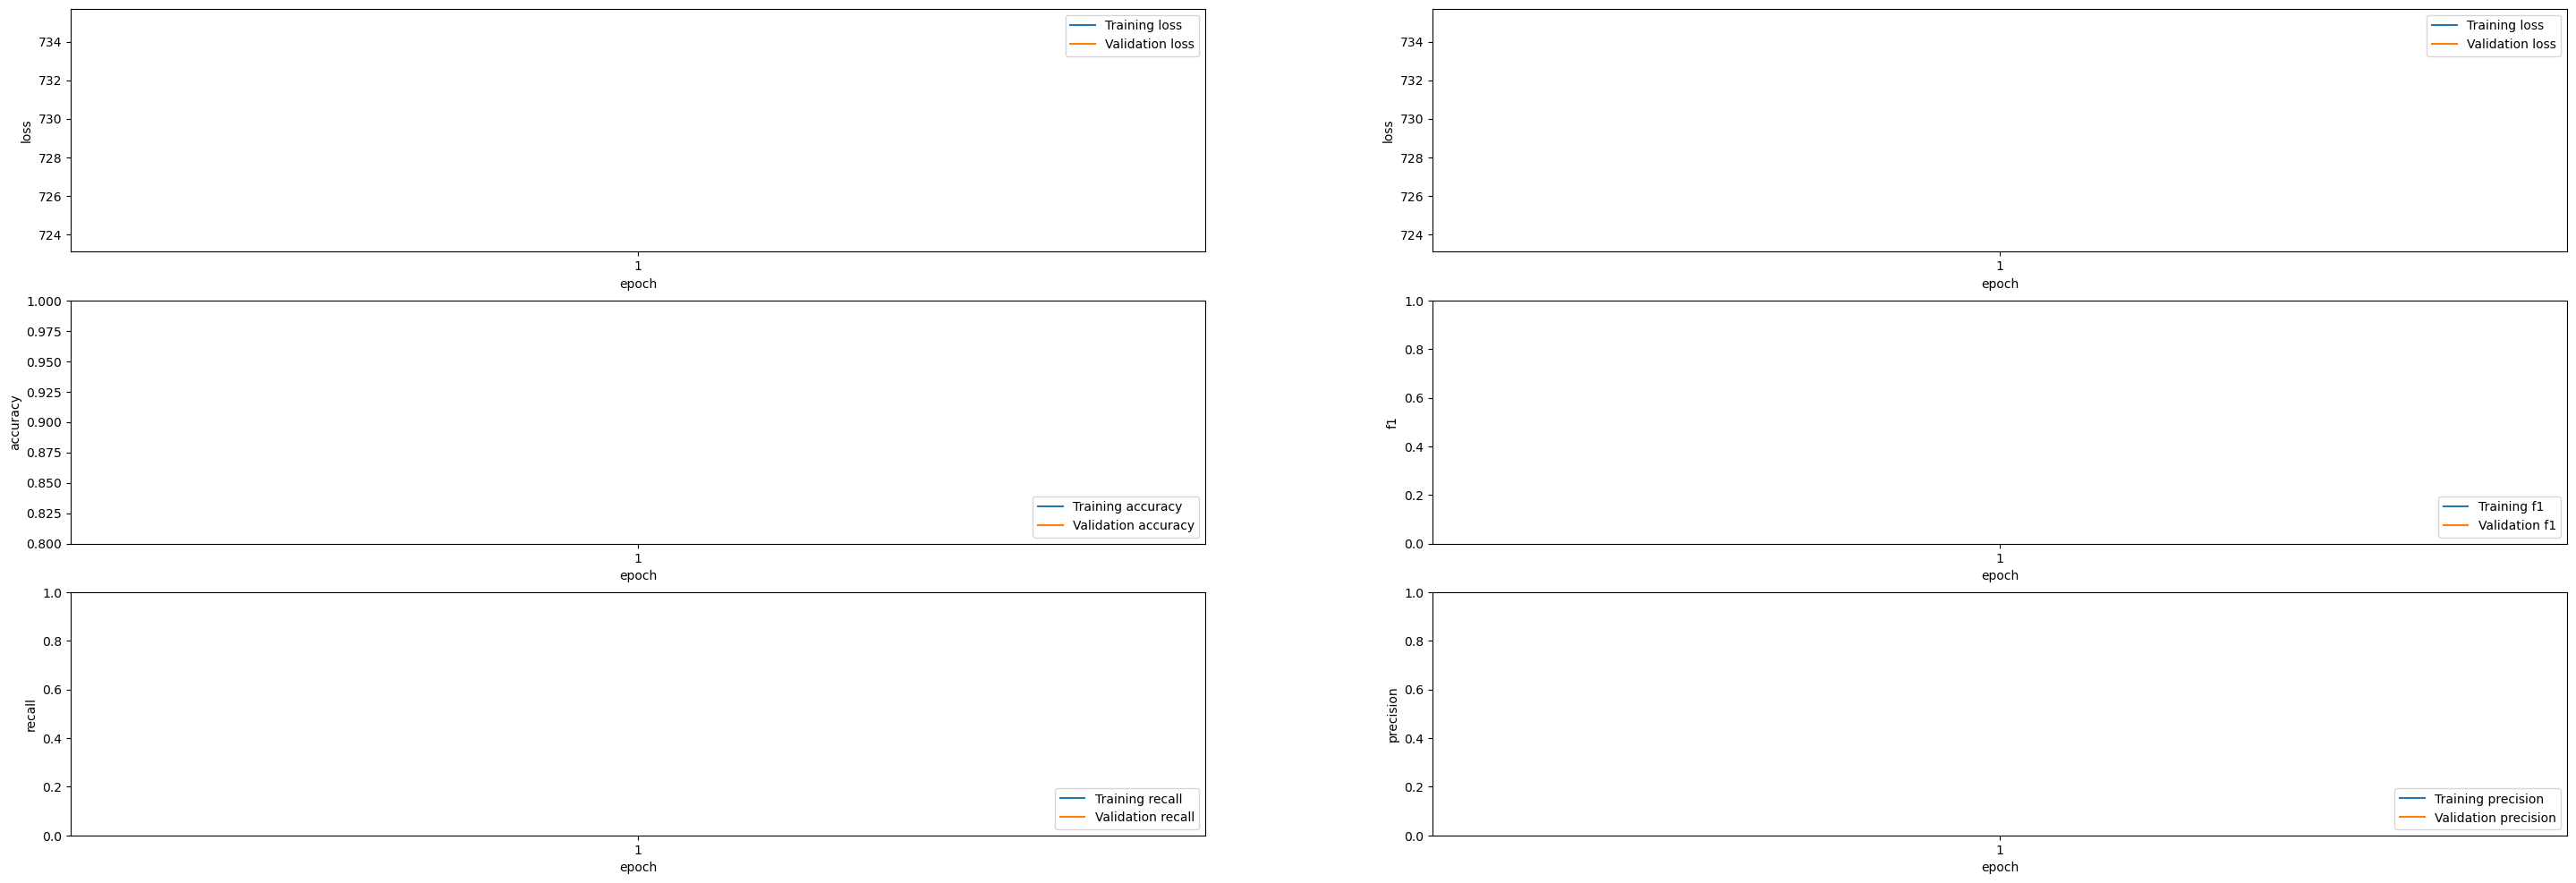

In [5]:
if Model.train_model:
    plot_losses = ["loss", "loss"]
    plot_metrics = ["accuracy", "f1", "recall", "precision"]

    path = os.path.join(Model.Data.paths["FIGURES"], "training.svg")

    plots.plot_training_history(history=history.history, list_of_loss_names=plot_losses,
                                list_of_metric_names=plot_metrics,
                                save=Model.cfg["SAVE"], path=path)

1/1 [==============================] - 1s 509ms/step


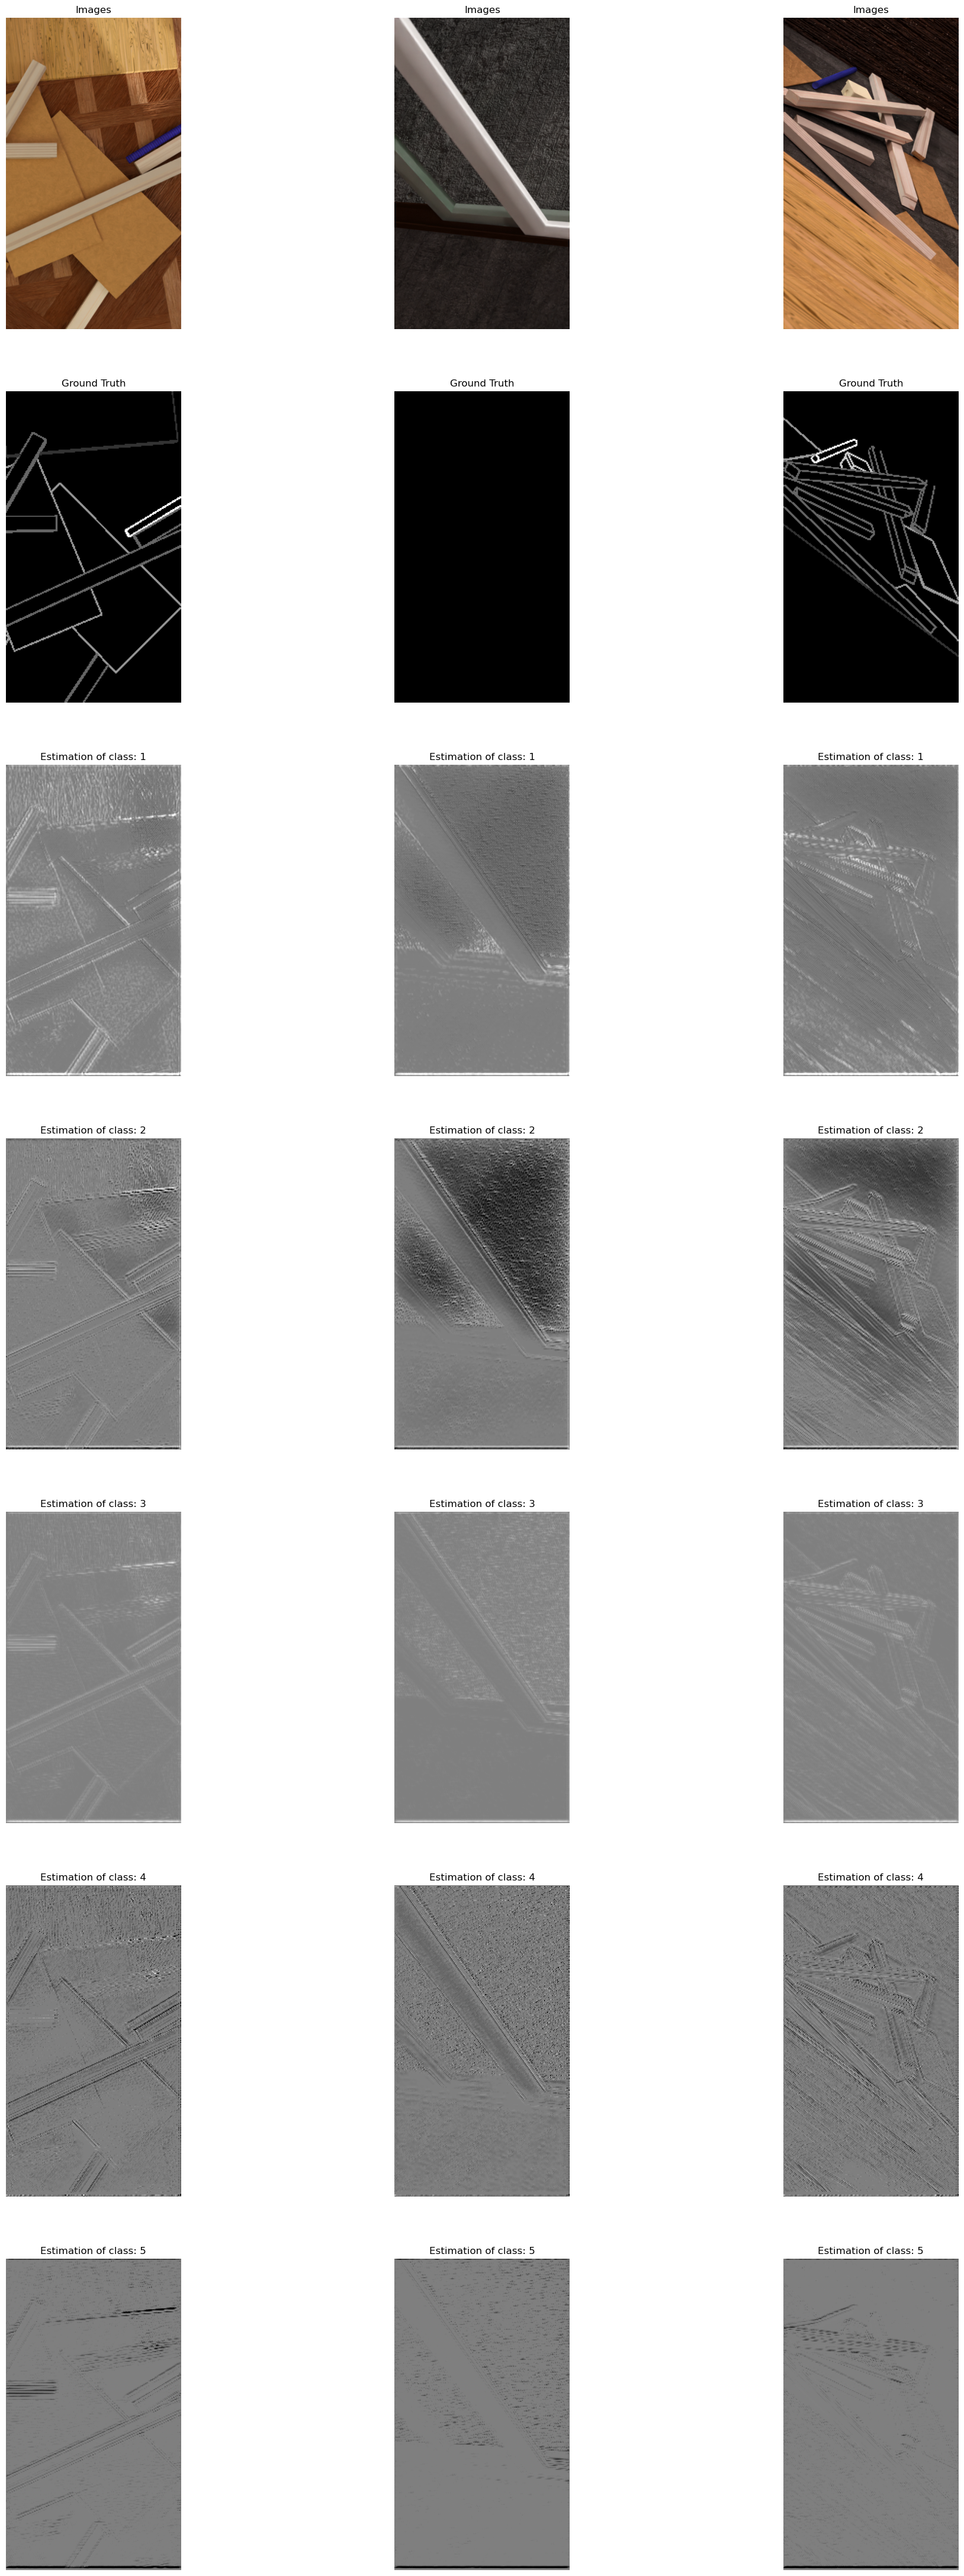

In [6]:
for inp, out in test_ds.take(1):
    pred = model.predict(inp)
    edge_detection_plots.plot_edges(images=inp['in_img'], labels=out['out_edge'],
                                    predictions=pred,
                                    batch_size=DataProcessing.cfg['TEST']['BATCH_SIZE'],
                                    num_classes=DataProcessing.num_classes['edge'])

Max Accuracy Score = 0.739 at 0.400
MF1 = 0.739
MF1_1 = 0.720, ODS_1 = 0.400
MF1_2 = 0.635, ODS_2 = 0.400
MF1_3 = 1.000, ODS_3 = 0.400
MF1_4 = 0.691, ODS_4 = 0.400
MF1_5 = 0.901, ODS_5 = 0.400
(3, 3)
(0, 1)
(0, 2)
(1, 6)
(1, 7)
(1, 8)
(2, 12)


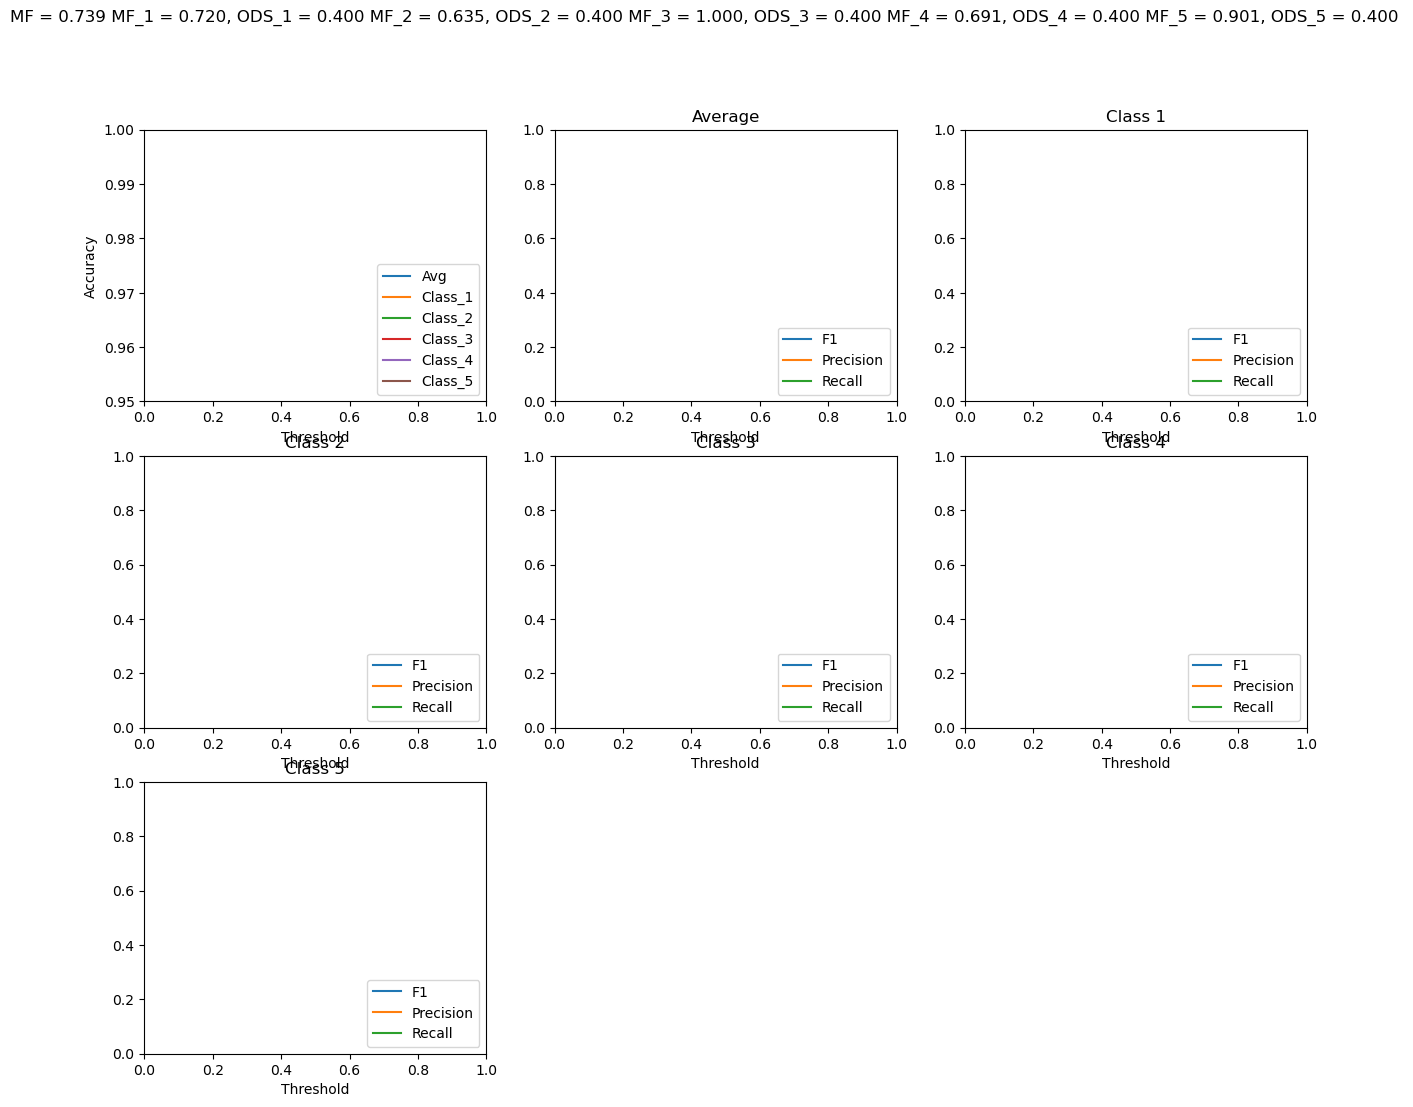

In [7]:
### Maximum F1 Score:

if Model.train_model:
    path_metrics_evaluation_plot = os.path.join(Model.Data.paths["FIGURES"],
                                                "threshold_metrics_evaluation_test_ds.svg")

    edge_detection_plots.plot_threshold_metrics_evaluation(model=model, ds=test_ds,
                                                           num_classes=DataProcessing.num_classes['edge'],
                                                           classes_displayed_individually=True,
                                                           save=Model.cfg["SAVE"],
                                                           path=path_metrics_evaluation_plot,
                                                           accuracy_y_lim_min=0.95)


# Evaluate on Test DS of Real Images

## Visual Results

# Save Model

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=Model.get_loss_function(),
              metrics=Model.get_metrics())

if Model.cfg["SAVE"]:
    model.save(Model.Data.paths["MODEL"])

    model = tf.keras.models.load_model(Model.Data.paths["MODEL"], custom_objects=Model.custom_objects)